# Imports

In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import warnings

warnings.filterwarnings("ignore")

# Vars

In [5]:
SEED = 34
N_FEATURES = 128

# Генерация набора данных

In [6]:
X, y = make_classification(
    n_samples=250,
    n_features=N_FEATURES,
    n_informative=4,
    n_redundant=124,
    n_repeated=0,
    n_classes=2,
    flip_y=0.1,
    class_sep=0.6,
    random_state=SEED,
)

# Предобработка

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

# Модель

In [8]:
class MLP(nn.Module):  # Усложняем модель для переобучения
    def __init__(self, input_size, dropout_rate=0.0):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.hidden3 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.dropout(x)
        x = self.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.relu(self.hidden3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

In [9]:
# Функция обучения + сохранения метрик
def train_and_evaluate(
    model, optimizer, criterion, X_train, y_train, X_test, y_test, epochs=500
):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Обучение
        model.train()
        optimizer.zero_grad()
        train_outputs = model(X_train)
        train_loss = criterion(train_outputs, y_train)
        train_loss.backward()
        optimizer.step()

        # Метрики обучения
        train_preds = (train_outputs > 0.5).float()
        train_accuracy = (train_preds == y_train).float().mean()

        # Метрики тестирования
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_preds = (test_outputs > 0.5).float()
            test_accuracy = (test_preds == y_test).float().mean()

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_accuracies.append(train_accuracy.item())
        test_accuracies.append(test_accuracy.item())

    return train_losses, test_losses, train_accuracies, test_accuracies

# Исследование оптимизаторов

In [10]:
def test_optimizers(optimizers, criterion, dropout_rate):
    results = {}
    for opt_name, opt_class in optimizers.items():
        model = MLP(input_size=N_FEATURES, dropout_rate=dropout_rate)

        if opt_name == "SGD":
            optimizer = opt_class(model.parameters(), lr=0.01)
        else:
            optimizer = opt_class(model.parameters(), lr=0.001)

        train_losses, test_losses, train_accuracies, test_accuracies = (
            train_and_evaluate(
                model, optimizer, criterion, X_train, y_train, X_test, y_test
            )
        )

        results[opt_name] = {
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies,
        }

        print(f"{opt_name}: ")
        print("\tAccuracy:")
        print(f"\t\tTraining: {train_accuracies[-1]:.4f}")
        print(f"\t\tTest: {test_accuracies[-1]:.4f}")
        print("\tLoss:")
        print(f"\t\tTraining: {train_losses[-1]:.4f}")
        print(f"\t\tTest: {test_losses[-1]:.4f}")
        print()
    return results

In [11]:
optimizers = {"SGD": optim.SGD, "Adam": optim.Adam, "RMSProp": optim.RMSprop}

criterion = nn.BCELoss()

results_without_dropout = test_optimizers(optimizers, criterion, 0.0)

results_with_dropout = test_optimizers(optimizers, criterion, 0.5)

SGD: 
	Accuracy:
		Training: 0.7371
		Test: 0.5867
	Loss:
		Training: 0.6386
		Test: 0.6529

Adam: 
	Accuracy:
		Training: 1.0000
		Test: 0.7867
	Loss:
		Training: 0.0008
		Test: 3.0645

RMSProp: 
	Accuracy:
		Training: 1.0000
		Test: 0.7600
	Loss:
		Training: 0.0101
		Test: 3.0231

SGD: 
	Accuracy:
		Training: 0.6286
		Test: 0.6533
	Loss:
		Training: 0.6689
		Test: 0.6674

Adam: 
	Accuracy:
		Training: 0.8229
		Test: 0.8133
	Loss:
		Training: 0.3878
		Test: 0.4317

RMSProp: 
	Accuracy:
		Training: 0.8400
		Test: 0.7600
	Loss:
		Training: 0.3460
		Test: 0.4744



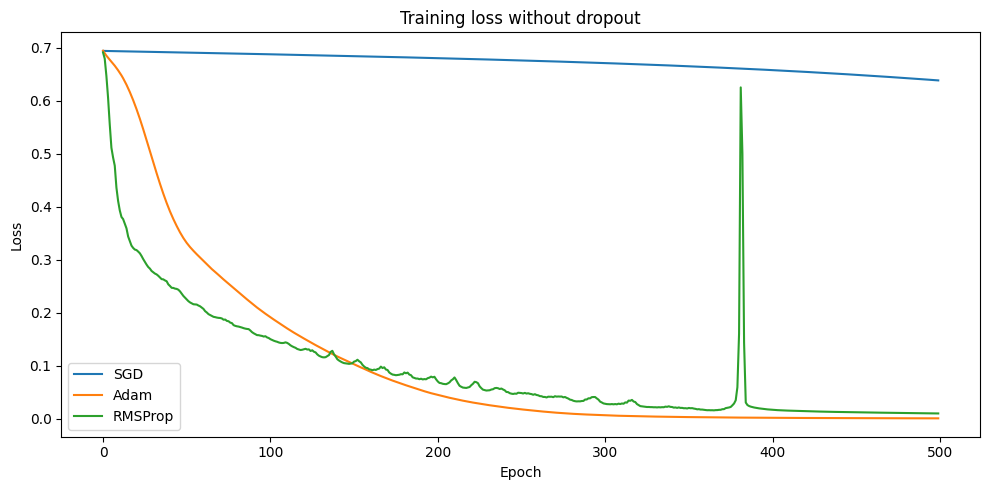

In [12]:
plt.figure(figsize=(10, 5))

for idx, opt_name in enumerate(optimizers.keys()):
    train_loss_no = results_without_dropout[opt_name]["train_losses"]

    plt.plot(train_loss_no, label=f"{opt_name}")

    plt.title("Training loss without dropout")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

plt.tight_layout()
plt.show()

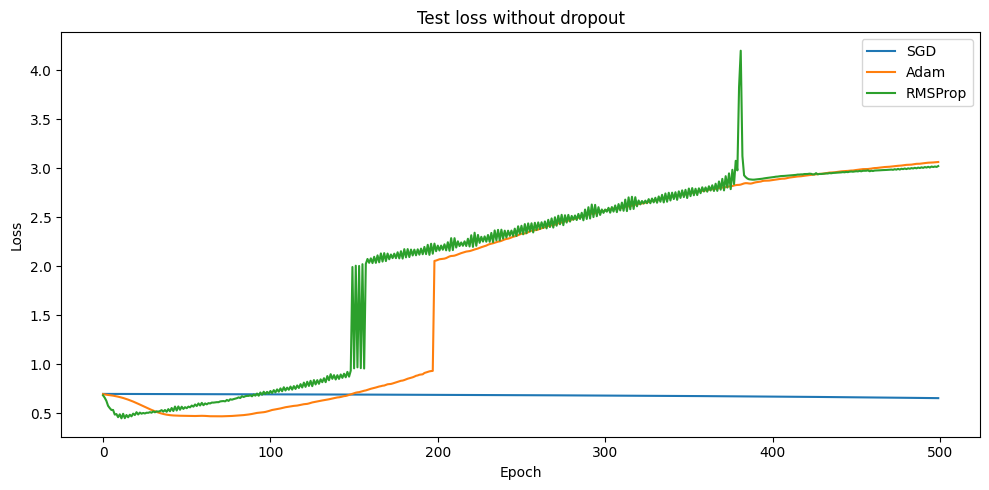

In [13]:
plt.figure(figsize=(10, 5))

for idx, opt_name in enumerate(optimizers.keys()):
    train_loss_no = results_without_dropout[opt_name]["test_losses"]

    plt.plot(train_loss_no, label=f"{opt_name}")

    plt.title("Test loss without dropout")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

plt.tight_layout()
plt.show()

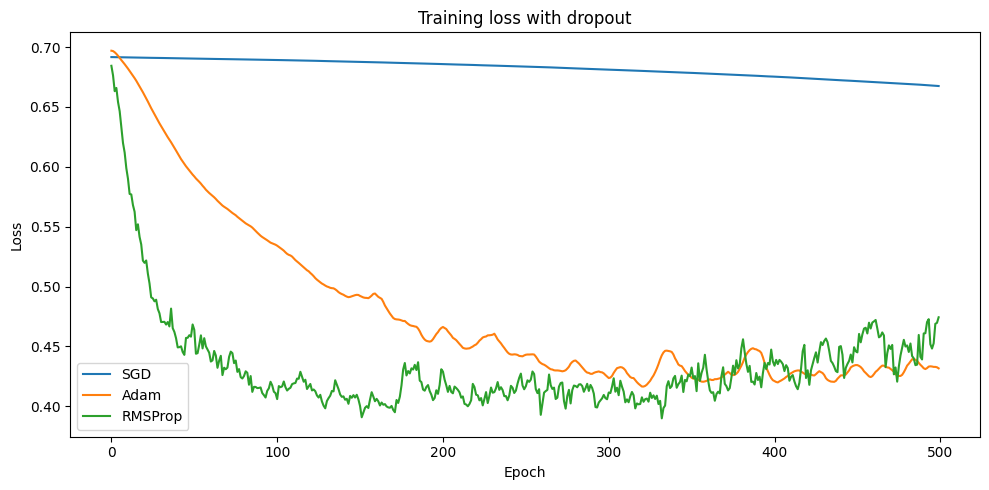

In [14]:
plt.figure(figsize=(10, 5))

for idx, opt_name in enumerate(optimizers.keys()):
    train_loss_with = results_with_dropout[opt_name]["test_losses"]

    plt.plot(train_loss_with, label=f"{opt_name}")

    plt.title("Training loss with dropout")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

plt.tight_layout()
plt.show()

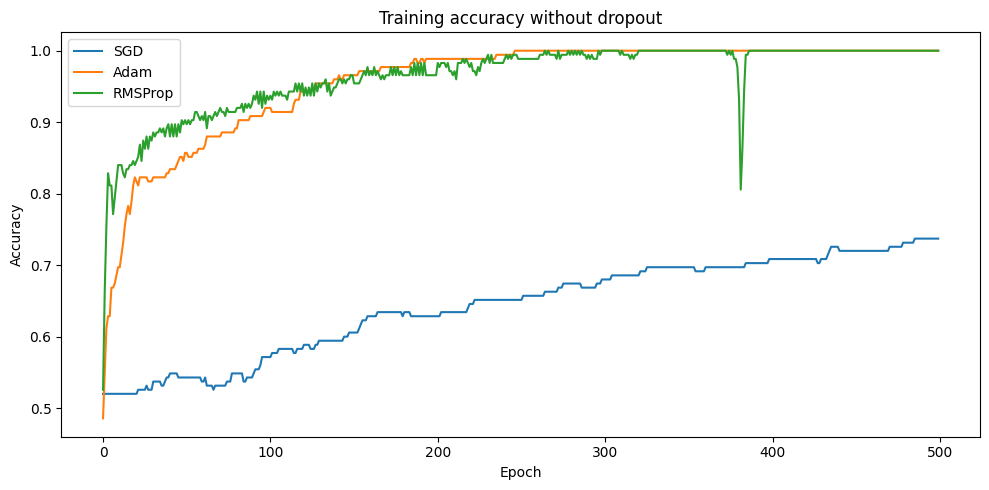

In [15]:
plt.figure(figsize=(10, 5))

for idx, opt_name in enumerate(optimizers.keys()):
    train_acc_no = results_without_dropout[opt_name]["train_accuracies"]

    plt.plot(train_acc_no, label=f"{opt_name}")

    plt.title("Training accuracy without dropout")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

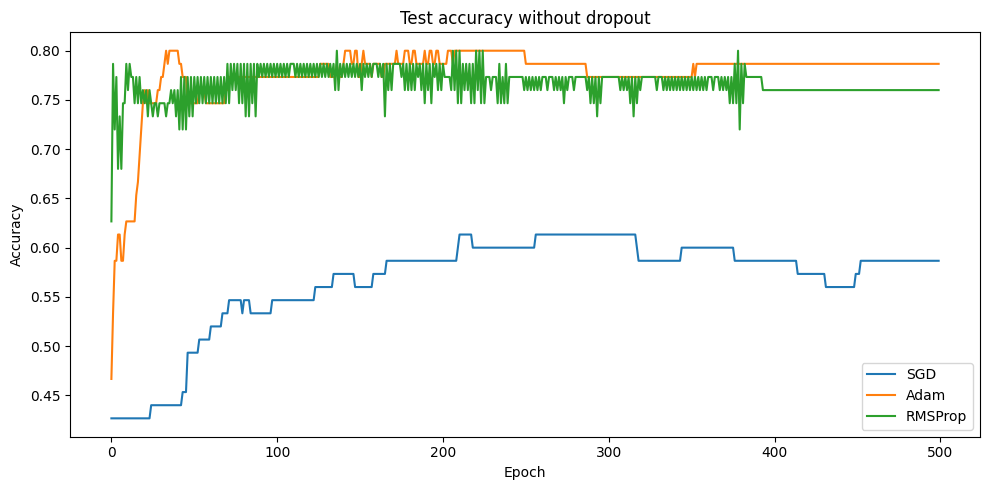

In [16]:
plt.figure(figsize=(10, 5))

for idx, opt_name in enumerate(optimizers.keys()):
    train_acc_no = results_without_dropout[opt_name]["test_accuracies"]

    plt.plot(train_acc_no, label=f"{opt_name}")

    plt.title("Test accuracy without dropout")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

PMSProp:
- Наиболее быстрая сходимость

SGD:
- Наиболее стабильная сходимость

Adam:
- Баланс

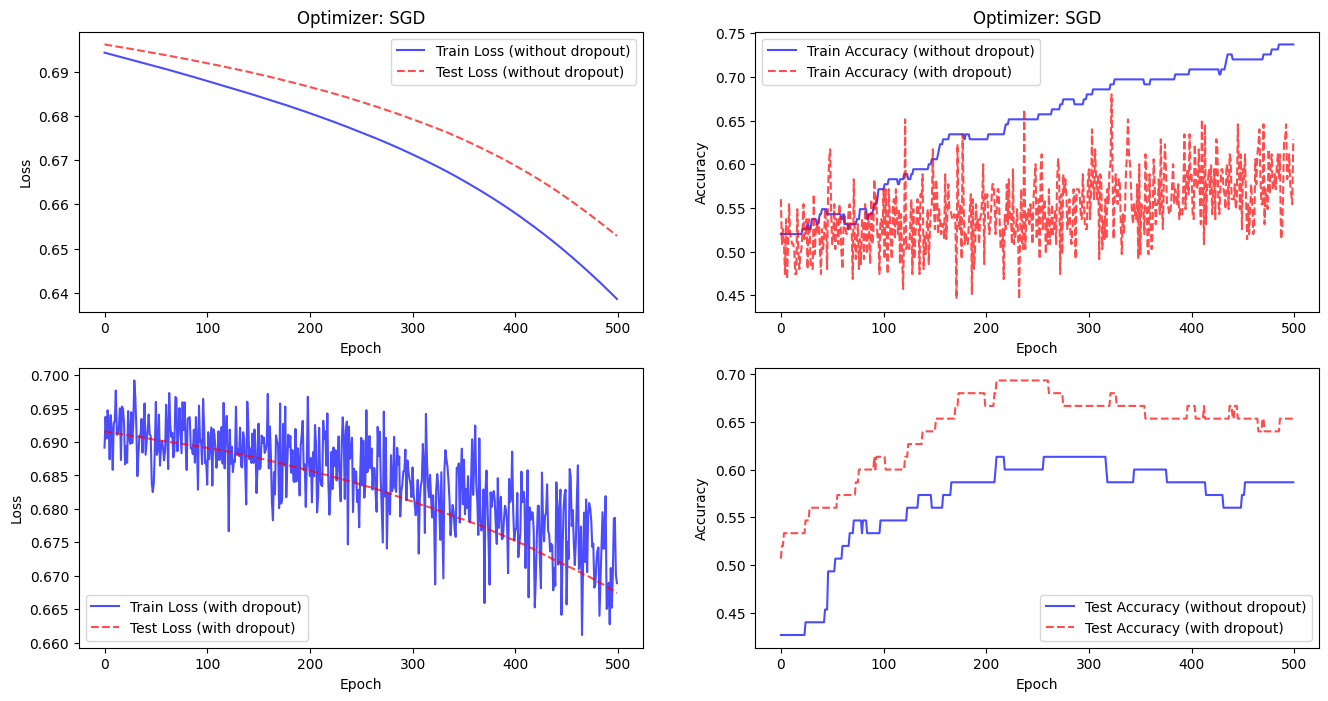

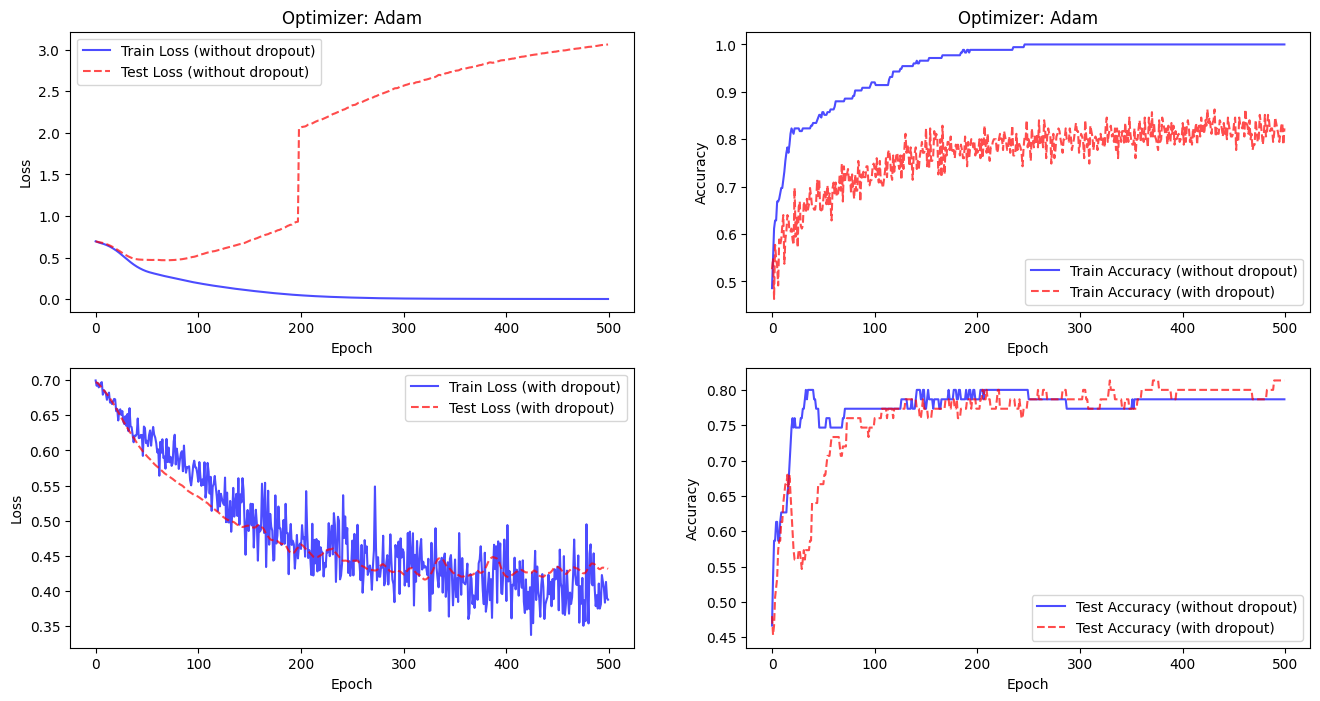

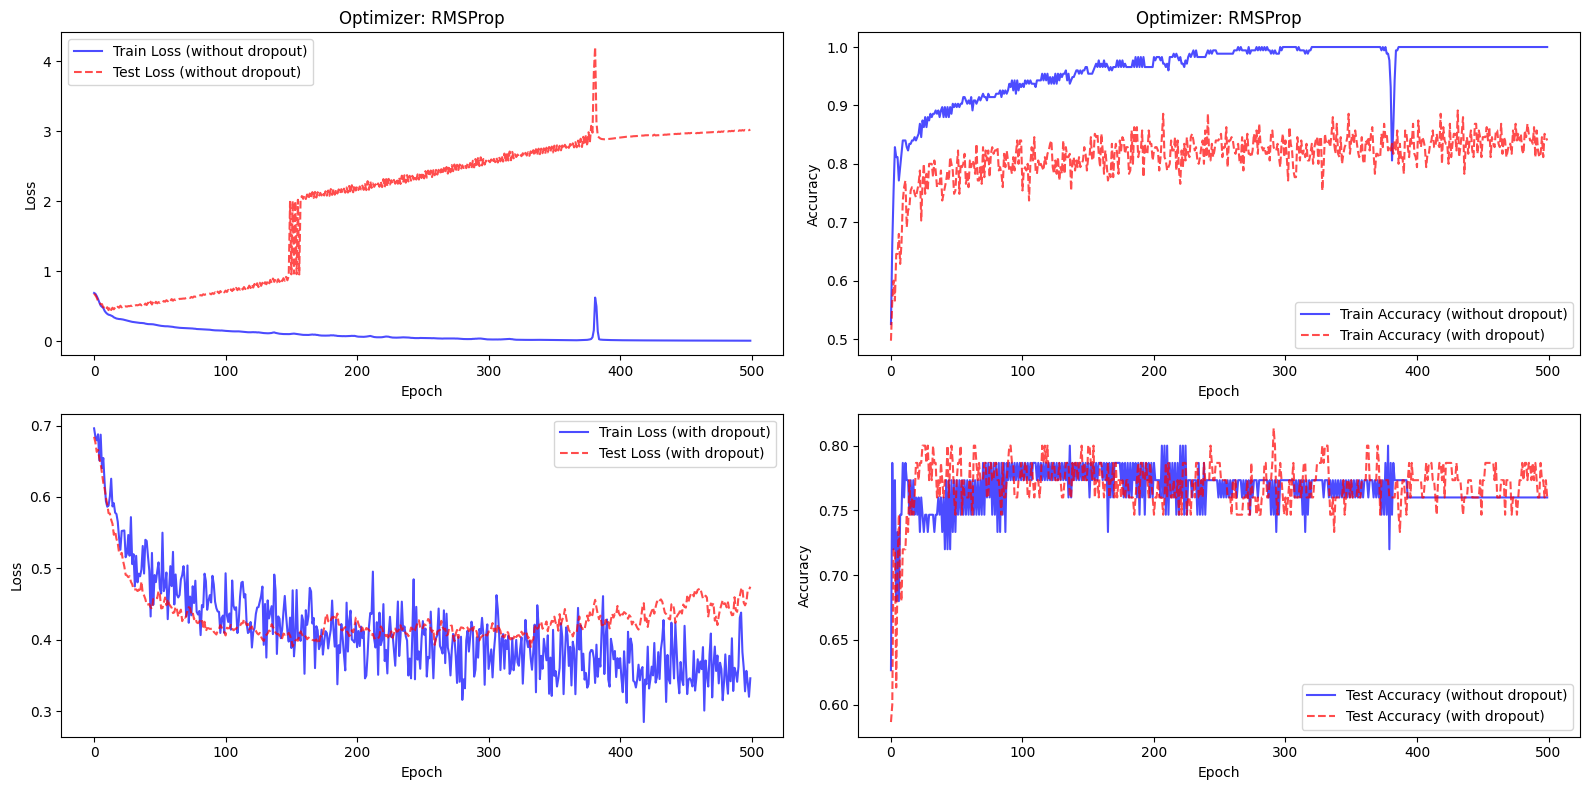

In [17]:
for idx, opt_name in enumerate(optimizers.keys()):

    plt.figure(figsize=(16, 8))

    train_loss_no = results_without_dropout[opt_name]["train_losses"]
    test_loss_no = results_without_dropout[opt_name]["test_losses"]
    train_loss_with = results_with_dropout[opt_name]["train_losses"]
    test_loss_with = results_with_dropout[opt_name]["test_losses"]

    plt.subplot(2, 2, 1)

    plt.plot(
        train_loss_no, label="Train Loss (without dropout)", color="blue", alpha=0.7
    )
    plt.plot(
        test_loss_no,
        label="Test Loss (without dropout)",
        color="red",
        alpha=0.7,
        linestyle="--",
    )

    plt.title(f"Optimizer: {opt_name}")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(2, 2, 3)

    plt.plot(
        train_loss_with, label="Train Loss (with dropout)", color="blue", alpha=0.7
    )
    plt.plot(
        test_loss_with,
        label="Test Loss (with dropout)",
        color="red",
        alpha=0.7,
        linestyle="--",
    )

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    train_acc_no = results_without_dropout[opt_name]["train_accuracies"]
    test_acc_no = results_without_dropout[opt_name]["test_accuracies"]
    train_acc_with = results_with_dropout[opt_name]["train_accuracies"]
    test_acc_with = results_with_dropout[opt_name]["test_accuracies"]

    plt.subplot(2, 2, 2)

    plt.plot(
        train_acc_no, label="Train Accuracy (without dropout)", color="blue", alpha=0.7
    )
    plt.plot(
        train_acc_with,
        label="Train Accuracy (with dropout)",
        color="red",
        alpha=0.7,
        linestyle="--",
    )

    plt.title(f"Optimizer: {opt_name}")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(2, 2, 4)

    plt.plot(
        test_acc_no, label="Test Accuracy (without dropout)", color="blue", alpha=0.7
    )
    plt.plot(
        test_acc_with,
        label="Test Accuracy (with dropout)",
        color="red",
        alpha=0.7,
        linestyle="--",
    )

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

Dropout немного уменьшает точность, но с ним модель лучше работает с шумом и не переобучается